<a href="https://colab.research.google.com/github/FabriceBeaumont/4216_Biomedical_DS_and_AI/blob/main/Sheet9/Assignment9_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
import skimage.measure

import tensorflow as tf

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict, train_test_split
from sklearn.calibration import calibration_curve

from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.wrappers.scikit_learn import KerasClassifier

In [44]:
# !pip install -q -U keras-tuner

In [45]:
import kerastuner as kt
from kerastuner import HyperModel

## Biomedical Data Science & AI

## Assignment 9

#### Group members:  Fabrice Beaumont, Fatemeh Salehi, Genivika Mann, Helia Salimi, Jonah

---
### Exercise 1 - Basics of NN

From the MNIST database load the handwritten digits dataset.

In [46]:
# Load the data: 
# Split between train and test sets w.r.t. data 'x' and class vectors 'y'
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

#### 1.1. Normalize your dataset before training your model.

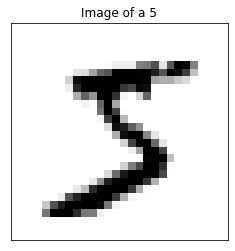

In [47]:
# For normalization we scale the images to contain values in [0, 1]
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Alternative approach:
# x_train = tf.keras.utils.normalize(x_train, axis=1)

# Print the first image to get an idea of the data
index = 0
_classification = y_train[0]
plt.imshow(x_train[0], cmap=plt.cm.binary); plt.title(f"Image of a {_classification}")
plt.xticks([]); plt.yticks([]); plt.show()

In [48]:
# Check, that all images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
input_shape = x_train[0].shape

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [49]:
# Check, if the number of classes is ten (since there are ten digits 0,...,9)
num_classes = 10

if num_classes == len(set(y_train)) == len(set(y_test)): print(f"There are {num_classes} classes.")

There are 10 classes.


#### 1.2. Train a neural network once using **Adam** and once using **AdaGrad** optimizer. 

*Hint*: Set epochs to $20$, neurons of hidden layer to $100$ and use the ReLU as activation function.

In [50]:
num_epochs = 20
num_hidden_neurons = 100
activation_fct = "relu"
# Alternative: 
# activation_fct = tf.nn.relu

loss = "sparse_categorical_crossentropy"

In [51]:
model = keras.Sequential(
    [
        # Input layer   (size 28x28 -> 784)
        keras.Input(shape=input_shape),
        layers.Flatten(),
     
        # One hidden layer  (size 'num_hidden_neurons'=100)
        layers.Dense(num_hidden_neurons, activation=activation_fct),

        # Output layer  (size 10)
        # Use 'softmax' to get a probability for the digits 0,...,9 as classification
        layers.Dense(num_classes, activation="softmax")
    ]
)

model.summary()

Model: "sequential_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_120 (Flatten)        (None, 784)               0         
_________________________________________________________________
dense_298 (Dense)            (None, 100)               78500     
_________________________________________________________________
dense_299 (Dense)            (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Compile the model with 'adam'
model.compile(loss=loss, optimizer="adam", metrics=["accuracy"])

# Train the model
# Also pass the validation data, because this way the history will contain
# the loss and accuracy w.r.t. to the validation data too (for later use)
%time history_adam = model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_test, y_test))

# Save the score (validation loss and validation accuracy) for later use
score_adam = model.evaluate(x_test, y_test, verbose=0)

Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2775 - accuracy: 0.9206 - val_loss: 0.1484 - val_accuracy: 0.9585
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1240 - accuracy: 0.9628 - val_loss: 0.1170 - val_accuracy: 0.9646
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0865 - accuracy: 0.9739 - val_loss: 0.0979 - val_accuracy: 0.9692
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0659 - accuracy: 0.9799 - val_loss: 0.0838 - val_accuracy: 0.9738
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0522 - accuracy: 0.9835 - val_loss: 0.0771 - val_accuracy: 0.9777
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0417 - accuracy: 0.9868 - val_loss: 0.0767 - val_accuracy: 0.9772
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0345 - accuracy: 0.9891 - val_loss: 0.0731 - val_accuracy:

In [53]:
# Now do the same using AdaGrad. First compile the model
model.compile(loss=loss, optimizer="adagrad", metrics=["accuracy"])

# Train the model
%time history_adagrad = model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_test, y_test))

# Save the score (validation loss and validation accuracy) for later use
score_adagrad = model.evaluate(x_test, y_test, verbose=0)

Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 0.0964 - val_accuracy: 0.9784
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.0947 - val_accuracy: 0.9790
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0936 - val_accuracy: 0.9797
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0024 - accuracy: 0.9996 - val_loss: 0.0928 - val_accuracy: 0.9798
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.0922 - val_accuracy: 0.9799
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.0918 - val_accuracy: 0.9804
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0019 - accuracy: 0.9998 - val_loss: 0.0914 - val_accuracy:

In [54]:
# Compare the scores of the two models
print(f'ADAM:    Validation loss: {score_adam[0]:.2f},\tValidation accuracy: {score_adam[1]*100:.2f} %')
print(f'ADAGRAD: Validation loss: {score_adagrad[0]:.2f},\tValidation accuracy: {score_adagrad[1]*100:.2f} %')

ADAM:    Validation loss: 0.10,	Validation accuracy: 97.74 %
ADAGRAD: Validation loss: 0.09,	Validation accuracy: 98.07 %


#### 1.3. Plot the *SparseCategoricalCrossentropy* loss for both models. Plot the computed accuracy for both models. Which model performed better while training?

In [55]:
history_adam.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

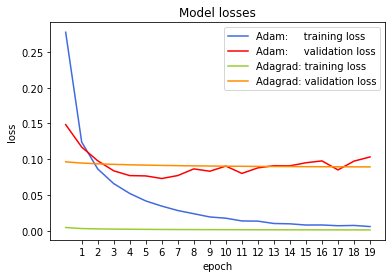

In [56]:
# Now plot the losses
plt.plot(history_adam.history['loss'], c="royalblue")
plt.plot(history_adam.history['val_loss'], c="red")

plt.plot(history_adagrad.history['loss'], c="yellowgreen")
plt.plot(history_adagrad.history['val_loss'], c="darkorange")

plt.title('Model losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(1, num_epochs))
plt.legend(['Adam:     training loss', 'Adam:     validation loss', 'Adagrad: training loss', 'Adagrad: validation loss'])
plt.show()

#### 1.4. Compute the model accuracy on the test set for both optimizers. Which model performed better?

In [57]:
print(f"The model using ADAM    reached an accuracy of {score_adam[1]*100:.2f} %.")
print(f"The model using ADAGRAD reached an accuracy of {score_adagrad[1]*100:.2f} %.")
print(f"Thus the model using ADAGRAD performed better.")

The model using ADAM    reached an accuracy of 97.74 %.
The model using ADAGRAD reached an accuracy of 98.07 %.
Thus the model using ADAGRAD performed better.


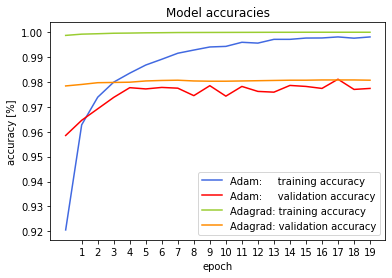

In [58]:
# Plot the accuracies
plt.plot(history_adam.history['accuracy'], c="royalblue")
plt.plot(history_adam.history['val_accuracy'], c="red")

plt.plot(history_adagrad.history['accuracy'], c="yellowgreen")
plt.plot(history_adagrad.history['val_accuracy'], c="darkorange")

plt.title('Model accuracies')
plt.ylabel('accuracy [%]')
plt.xlabel('epoch')
plt.xticks(range(1, num_epochs))
plt.legend(['Adam:     training accuracy', 'Adam:     validation accuracy', 'Adagrad: training accuracy', 'Adagrad: validation accuracy'])
plt.show()

#### 1.5. Familiarize yourself with **Layer Normalization** and explain how it works.

**Layer normalization** is the process of normalizing the activations of layers *for each given example* in a batch *independently*. 

Thus it is similar to batch normalization, but does not have the same limitations. Limitations of batch normalization that layer normalization does not have are:
- normalization accross a batch and thus dependent of the other examples in the batch
- no obvious application to *recurrent NN* (*RNN*): The summed inputs often vary with the length of the sequence!
- no application to online learning algorithms

Furthermore, unlike batch normalization, layer
normalization performs exactly the same computation at training and *validation*.

Important **benefits** of batch normalization are also given by layer normalization:
- stabilizes the hidden state dynamics in recurrent networks
- can substantially reduce the training time

###### Mathematical description of layer normalization:

Let 
- $a^l$ be the vector representation of the summed inputs to the neurons in layer $l$,
- $W^l$ be the weights between layer $l-1$ and $l$,
- $x^l$ the inputs for layer $l$,
- $b^l$ the bias of layer $l$ and
- $f$ activation function.

It is
$$ a_i^l = {w_i^l}^\intercal x^l ,\qquad\qquad x_i^{l+1} =f\big( a_i^l + b_i^l \big) $$

For layer normalization, adjust the mean and variance of every layer to be the mean and variance over *all hidden units in the same layer*. Let $l$ be a layer with $H$ neurons. Define
$$ \mu^l := \frac{1}{H} \sum_{i=1}^{H} a_i^l,\qquad\qquad \sigma^l := \sqrt{ \frac{1}{H} \sum_{i=1}^{H} (a_i^l-\mu^l)^2 } $$

###### Source:
- ["Layer Normalization"](https://arxiv.org/pdf/1607.06450v1) by Jimmy Lei Ba, Jamie Ryan Kiros and Geoffrey E. Hinton (2016)

#### 1.6. Use the same dataset to train a neural network with Layer Normalization.

In [59]:
model = keras.Sequential(
    [
        # Input layer   (size 28x28 -> 784)
        keras.Input(shape=input_shape),
        layers.Flatten(),
        # TODO: since the input was originally normalized, if this necessary here too?
        layers.LayerNormalization(axis=1),
     
        # One hidden layer  (size 'num_hidden_neurons'=100)
        layers.Dense(num_hidden_neurons, activation=activation_fct),
        layers.LayerNormalization(axis=1),

        # Output layer  (size 10)
        # Use 'softmax' to get a probability for the digits 0,...,9 as classification
        layers.Dense(num_classes, activation="softmax")
    ]
)

model.summary()

Model: "sequential_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_121 (Flatten)        (None, 784)               0         
_________________________________________________________________
layer_normalization (LayerNo (None, 784)               1568      
_________________________________________________________________
dense_300 (Dense)            (None, 100)               78500     
_________________________________________________________________
layer_normalization_1 (Layer (None, 100)               200       
_________________________________________________________________
dense_301 (Dense)            (None, 10)                1010      
Total params: 81,278
Trainable params: 81,278
Non-trainable params: 0
_________________________________________________________________


In [60]:
# Lets use AdaGrad, since it performed better. First compile the model
model.compile(loss=loss, optimizer="adagrad", metrics=["accuracy"])

# Train the model
%time history = model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_test, y_test))

# Save the score (validation loss and validation accuracy) for later use
score = model.evaluate(x_test, y_test, verbose=0)

Epoch 1/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6289 - accuracy: 0.8158 - val_loss: 0.3918 - val_accuracy: 0.8933
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3660 - accuracy: 0.8985 - val_loss: 0.3210 - val_accuracy: 0.9138
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3144 - accuracy: 0.9129 - val_loss: 0.2891 - val_accuracy: 0.9222
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2854 - accuracy: 0.9212 - val_loss: 0.2671 - val_accuracy: 0.9264
Epoch 5/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2653 - accuracy: 0.9265 - val_loss: 0.2515 - val_accuracy: 0.9303
Epoch 6/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2500 - accuracy: 0.9311 - val_loss: 0.2394 - val_accuracy: 0.9335
Epoch 7/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2379 - accuracy: 0.9347 - val_loss: 0.2292 - val_accuracy:

##### 1.6.a. Compute the SparseCategoricalCrossentropy loss and model accuracy.

In [61]:
print(f'ADAGRAD with layer normlization:\nValidation loss: {score[0]:.2f},\tValidation accuracy: {score[1]*100:.2f} %')

ADAGRAD with layer normlization:
Validation loss: 0.17,	Validation accuracy: 95.22 %


##### 1.6.b. Evaluate the model performance using the test dataset.

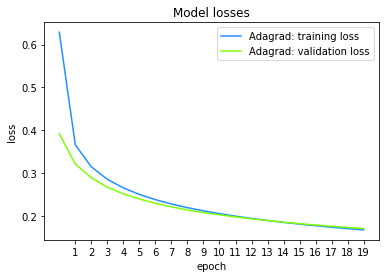

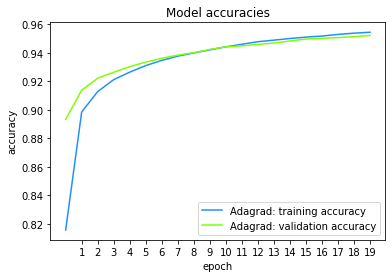

In [62]:
singular = ['loss', 'accuracy']
plural = ['losses', 'accuracies']

for i in range(len(singular)):
    mode = singular[i]

    plt.plot(history.history[mode], c="dodgerblue")
    plt.plot(history.history[f"val_{mode}"], c="chartreuse")

    plt.title(f"Model {plural[i]}")
    plt.ylabel(mode)
    plt.xlabel('epoch')
    plt.xticks(range(1, num_epochs))
    plt.legend([f"Adagrad: training {mode}", f"Adagrad: validation {mode}"])
    plt.show()

Just from looking at the plots we can see that the training went as desired: The loss steadily decreased while the accuracy increased.

Interestingly, the to be expected relation that the loss on the validation set is higher and the accuracy lower than on the training set is only the case after already 5 and 10 epochs.

We can see that around epoch 10, the loss on the training data gets lower, than on the validation loss. But the loss on the validation data still decreases, thus one can continue the training.

---
### Exercise 2 - Hyper Parameter Optimization

#### 2.1. What are the main challenges with hyper-parameter optimization for neural networks?

Typical challenges with hyper-parameter optimization (HPO) for NN are:
- hyper-parameters may be *continuous* or *discrete*/*categorical* 
(thus: use methods like grid search, random search,...)
- different *sensitivity* of the model with respect to different parameters
- large number of hyper-parameters
- complex models
- time-consuming model evaluations
- the choice of hyper-parameters may influence the *duration of training* significantly
- non-linear hyper-parameter interactions

###### Source:
- ["On Hyperparameter Optimization of Machine Learning Algorithms: Theory and Practice"](https://arxiv.org/pdf/2007.15745) by Li Yang and Abdallah Shami (2010)

##### 2.2. Inform yourself about variants of **Bayesian-HPO** and explain them in detail.

**Bayesian optimization** is a method to model the generalization performance of a learning algorithm as a *sample from a Gaussian process* (*GP*). That means to find the minimum of a function $f(x)$ on some bounded set $X\subset\mathbb{R}^D$ by constructing a probabilisitic model for $f(x)$ and exploit it to make the next evaluations of $f$ in $X$.

Since the evaluations $f(x)$ are expensive to perform (train and evaluate the learning algorithm on the new hyper-parameters $x$), it is justified, that more effort in the selection of the $x$ is made.

###### DEFINITION: **Gaussian process** (**GP**)
A GP is a (prior) distribution on functions $f:X\to\mathbb{R}$ such that any finite set of $N$ points $\{ x_n\in X \}_{n=1}^{N}$ induces a multivariate Gaussian distribution on $\mathbb{R}^N$.

Now assume that $f(x)$ is drawn from a GP piror and that the observations/data are of the form $\{x_n, y_n\}_{n=1}^{N}$ where $y_n\sim\mathcal{N}\big( f(x_n), \nu \big)$ where $\nu$ is the *variance of noise* in the data.

###### Sources:
- ["A Tutorial on Bayesian Optimization of
Expensive Cost Functions, with Application to
Active User Modeling and Hierarchical
Reinforcement Learning"](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiu7dC8rb7xAhXigP0HHTKDDOkQFnoECAUQAw&url=https%3A%2F%2Fwww.semanticscholar.org%2Fpaper%2FA-Tutorial-on-Bayesian-Optimization-of-Expensive-to-Brochu-Cora%2Fcd5a26b89f0799db1cbc1dff5607cb6815739fe7&usg=AOvVaw37GVu2ur6fAx3O7QkBwaes) by Eric Brochu, Vlad M. Cora and Nando de Freitas (2010)
- ["Practical Bayesian Optimization of Machine
Learning Algorithms"](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwi58fbIrb7xAhV-hP0HHbwrAu8QFnoECAcQAw&url=https%3A%2F%2Fpapers.nips.cc%2Fpaper%2F4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf&usg=AOvVaw1vwF0dYZpS1XkJbJjbuRIG) by Jasper Snoek, Hugo Larochelle and Ryan P. Adams (2021)
- ["Hyperopt: A Python Library for Optimizing the
Hyperparameters of Machine Learning Algorithms"](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiu0NXprb7xAhXKhv0HHWmaAq8QFnoECAQQAw&url=https%3A%2F%2Fconference.scipy.org%2Fproceedings%2Fscipy2013%2Fpdfs%2Fbergstra_hyperopt.pdf&usg=AOvVaw1T3FFVZlILsBGulTAL4ByO) by James Bergstra, Dan Yamins and David D. Cox (2013)


#### 2.3. Using the same MNIST dataset, optimize the activation function for the output layer and the number of dropout units in the NN model using the following methods.

In [63]:
###### For preparation do the same as in exercise 1.1.: ######
# Load the data: 
# Split between train and test sets w.r.t. data 'x' and class vectors 'y'
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# For normalization we scale the images to contain values in [0, 1]
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

# Check, that all images have shape (28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
input_shape = X_train[0].shape

In [64]:
num_classes = 10

##### 2.3.a. Grid search

In [65]:
# Create a wrapper for the model (required by KerasClassifier)
def build_model(activation = 'relu', rate = 0.2):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten())
    
    # Input layer
    model.add(keras.layers.Dense(128, activation = 'relu')) 
    
    # Hidden layer
    model.add(keras.layers.Dense(100, activation = 'relu')) 
    model.add(keras.layers.Dropout(rate = rate))

    # Output layer
    model.add(keras.layers.Dense(10, activation = activation)) 
    
    model.compile(loss ='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [66]:
# create nn model with Keras Classifier
nn_model = KerasClassifier(build_fn = build_model, verbose = 0)

In [67]:
# Define the grid search parameters
param_grid = {
    'activation': ['relu', 'softmax', 'sigmoid'],
    'rate': [0.2, 0.4, 0.6, 0.8]
}

grid_search = GridSearchCV(
    estimator = nn_model,
    param_grid = param_grid,
)

In [68]:
# Apply the grid Search
%time grid_search_result = grid_search.fit(X_train, y_train)

CPU times: user 5min 47s, sys: 22.8 s, total: 6min 10s
Wall time: 5min 38s


In [69]:
# Grid Search Performance
print(f"Best parameter settings are:\n{grid_search_result.best_params_}")
print(f"\n\nWith an accuracy of {grid_search_result.best_score_*100:.2f} %.")

Best parameter settings are:
{'activation': 'sigmoid', 'rate': 0.2}


With an accuracy of 95.70 %.


##### 2.3.a. Random search

In [73]:
class SequentialHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        
    def build(self, hp):
        model = keras.models.Sequential()
        model.add(keras.layers.Flatten())

        # Input layer
        model.add(keras.layers.Dense(self.input_shape, activation = 'relu')) 
        
        # Hidden layer
        model.add(keras.layers.Dense(100, activation = 'relu')) 
        model.add(keras.layers.Dropout(rate = hp.Choice('rate', values = [0.2, 0.4, 0.6, 0.8])))
        
        # Output layer
        model.add(keras.layers.Dense(self.num_classes, activation = hp.Choice('activation', values = [ 'relu', 'softmax', 'sigmoid'] ))) 
        
        model.compile(loss ='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
        return model

In [74]:
# Create a hypermodel instance
hypermodel = SequentialHyperModel(input_shape = 128, num_classes = num_classes)

In [75]:
# Create a Random Search hyperparameter tuner
tuner = kt.RandomSearch(
    hypermodel = hypermodel,
    objective = 'accuracy',
    max_trials = 10,
    directory = 'RSHO',
    project_name = 'Random Search'
)

In [78]:
# Execute the search by the tuner
%time tuner.search(x = X_train, y = y_train, epochs = 10, verbose = 0)

INFO:tensorflow:Oracle triggered exit
CPU times: user 9min 23s, sys: 36.8 s, total: 9min 59s
Wall time: 6min 45s


In [79]:
# Report the found parameters
tuner_results = tuner.get_best_hyperparameters()[0]
best_model = tuner.get_best_models(num_models = 1)[0]
loss, accuracy = best_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 1ms/step - loss: 0.1029 - accuracy: 0.9751


In [80]:
print("Best params are:\nrate: {}, activation: {}".format(
    tuner_results.get('rate'),
    tuner_results.get('activation')
))

print(f"\n\nWith an accuracy of {accuracy*100:.2f} % and a loss of {loss}.")

Best params are:
rate: 0.2, activation: softmax


With an accuracy of 97.51 % and a loss of 0.10285230726003647.


##### 2.3.a. Bayesian Hyper-parameter optimization

In [81]:
# Create a Bayesian Optimization hyperparameter tuner
tuner = kt.BayesianOptimization(
    hypermodel = hypermodel,
    objective = 'accuracy',
    max_trials = 10,
    directory = 'BHO',
    project_name = 'BayesianOptimisation'
)

In [83]:
# Execute the search by the tuner
%time tuner.search(x = X_train, y = y_train, epochs = 10, verbose = 0)

INFO:tensorflow:Oracle triggered exit
CPU times: user 9min 19s, sys: 36.8 s, total: 9min 56s
Wall time: 6min 46s


In [84]:
# Report the found parameters
print("Best params are:\nrate: {}, activation: {}".format(
    tuner_results.get('rate'),
    tuner_results.get('activation')
))

print(f"\n\nWith an accuracy of {accuracy*100:.2f} % and a loss of {loss}.")

Best params are:
rate: 0.2, activation: softmax


With an accuracy of 97.51 % and a loss of 0.10285230726003647.


---
### Exercise 3 - Transfer Learning & CNNs

#### 3.1. Load the *VGG16 pre-trained model* using Keras Applications API. Use the model to classify the dog images in canines.zip after pre-processing each image by doing the following:

(*See [MachineLearningMastery](ttps://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/) for reference*)

In [85]:
model = VGG16()
model.summary()

553476096/553467096 [==============================] - 8s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

##### 3.1.a. Load each image and set the size to 224 x 224 pixels.

##### 3.1.b. Convert the image pixels to a numpy array and reshape it according to the model’s input requirements.

##### 3.1.c. Use the model to print out the predicted class and its probability for each image.

In [91]:
image_target_size = (224, 224)

for image_number in range(1,9):
  # Load an image from file
  image = load_img("dog"+str(image_number)+".jpg", target_size=image_target_size)

  # Convert the image pixels to a numpy array
  image = img_to_array(image)

  # Reshape the data for the model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

  # Prepare the image for the VGG model
  image = preprocess_input(image)
  
  # Predict the probability across all output classes
  %time yhat = model.predict(image)
  
  # Convert the probabilities to class labels
  label = decode_predictions(yhat)
  
  # Retrieve the most likely result, e.g. highest probability
  label = label[0][0]
  
  # Print the classification
  print('Image Number %d:\t %s (%.2f%%)\n' % (image_number, label[1], label[2]*100))

CPU times: user 1.08 s, sys: 701 µs, total: 1.08 s
Wall time: 613 ms
Image Number 1:	 Doberman (93.43%)

CPU times: user 1.08 s, sys: 1.38 ms, total: 1.08 s
Wall time: 599 ms
Image Number 2:	 Pembroke (74.57%)

CPU times: user 1.09 s, sys: 2.19 ms, total: 1.09 s
Wall time: 631 ms
Image Number 3:	 golden_retriever (78.78%)

CPU times: user 1.07 s, sys: 6.86 ms, total: 1.08 s
Wall time: 600 ms
Image Number 4:	 Border_collie (70.29%)

CPU times: user 1.09 s, sys: 2.89 ms, total: 1.09 s
Wall time: 631 ms
Image Number 5:	 Great_Dane (45.38%)

CPU times: user 1.08 s, sys: 5.51 ms, total: 1.08 s
Wall time: 619 ms
Image Number 6:	 Great_Dane (90.89%)

CPU times: user 1.08 s, sys: 4.67 ms, total: 1.08 s
Wall time: 597 ms
Image Number 7:	 Eskimo_dog (49.96%)

CPU times: user 1.07 s, sys: 6.74 ms, total: 1.08 s
Wall time: 611 ms
Image Number 8:	 Doberman (35.42%)



#### 3.2. Downscale the given matrix by applying the following pooling operations:

**Note**: It is not specified, what the pooling size should be. We will use $3\times 3$.

In [132]:
pooling_size = 3

##### 3.2.a. Max Pool

In [143]:
# Visualize the pooling effect for one image
import PIL

img = PIL.Image.open("dog1.jpg")

# Convert the image pixels to a numpy array
image = np.array(img)

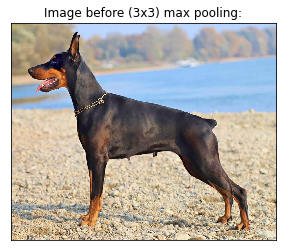

In [144]:
# View the image before application of the max-pooling
plt.imshow(image, interpolation='nearest')
plt.title(f"Image before ({pooling_size}x{pooling_size}) max pooling:")
plt.xticks([]); plt.yticks([]); plt.show()

##### 3.2.a. Average Pool

#### 3.3. Load the **CIFAR10 dataset** using Keras datasets API and normalize the images’ pixel values. Train a convolutional neural network to classify the dataset images with the following architecture:

##### 3.3.a. Convolutional Base:
1. An input convolution layer with $32$ filters and a kernel size of $(3,3)$.
Adjust your input shape to that of the CIFAR images’ format
2. Two convolution layers, each with 64 filters and a kernel size of $(3,3)$
3. Two Max Pool layers, with a pool size of $2\times 2$

##### 3.3.b. Two dense layers, with $64$ and $10$ units respectively. Adjust the output of the convolutional base such that it satisfies the input requirements of the dense layers.

##### 3.3.c. Use the following parameters to train the network:
1. Sparse categorical cross entropy as your loss function
1. Adam optimizer
1. $10$ epochs
1. ReLU activation for your layers

Compile your model, then plot the accuracy across each epoch.